# Active Learning and Uncertainty Sampling

In this exercise we are going to look at uncertainty sampling in the context of classifying flowers from the famous iris dataset. This dataset contains three classes (different species of flowers from the iris family) and four features (measurements of length and width of sepals and petals). This exercise is structured as follows:

- First, you will implement three strategies for uncertainty sampling (least confident, maximum margin, entropy). We start by considering only two classes (and, to be able to visualize the results, we will select only two features as well). In this case, all the strategies should agree on the most uncertain point. Subsequently, we will extent this to three classes and see how this affects the uncertainty estimates.
- Next, you will implement active learning based on these sampling strategies and compare with random sampling (using all features and classes).

The purpose of this exercise is to become familiar with the different strategies for uncertainty sampling and how it can be used in an active learning context.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

# plt.style.use('dark_background') # if you use a dark theme you might prefer this

In [2]:
# This cell contains various utility functions for preparing the dataset and plotting results.

def plot_grid(probabilities, least_confident, maximum_margin, entropy, data, grid, imshow_kwargs):
    """Plot the probabilities of each class from the logistic regression classifier
    (numpy array with shape [n_points, n_classes, 3]) along with the result of
    applying each sampling strategy (numpy arrays with shape [n_points, n_classes]).

    (Some additional variables are needed for making the plots.)
    """
    n1, n2 = grid.shape[1:]

    # This is just to be able to plot the two class problem as RGB
    # (ignore the blue channel)
    n_classes = probabilities.shape[-1]
    if n_classes == 2:
        probabilities = np.column_stack((probabilities, np.zeros(len(probabilities))))

    plot_dict = {
        'Probabilities': {
            'data': probabilities.reshape(n1, n2, 3).transpose(1,0,2),
            'point to mark': None
        },
        'Least Confident': {
            'data': least_confident.reshape(n1, n2).T,
            'point to mark': 'max'
        },
        'Maximum Margin': {
            'data': maximum_margin.reshape(n1, n2).T,
            'point to mark': 'min'
        },
        'Entropy': {
            'data': entropy.reshape(n1, n2).T,
            'point to mark': 'max'
        }
    }
    # Make the plot
    # (please ignore the colormap of the 'Probabilities' plot. It should not be
    # there!)
    fig = plt.figure(figsize=(12, 12))
    imgrid = ImageGrid(fig, 111,
                    nrows_ncols=(2,2),
                    axes_pad=(0.15, 0.35),
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="each",
                    )
    for ax, name in zip(imgrid, plot_dict):
        pd = plot_dict[name]
        im = ax.imshow(pd['data'], **imshow_kwargs)
        ax.cax.colorbar(im)
        ax.scatter(*data['train']['X'].T, c=data['train']['y'], cmap='jet')
        g = ax.scatter(*data['pool']['X'].T, c=data['pool']['y'], cmap='jet')
        g.set_facecolors('none')
        title = name
        # Mark max/min
        if pd['point to mark'] is not None:
            if pd['point to mark'] == 'max':
                point = np.where(pd['data'] == pd['data'].max())
            elif pd['point to mark'] == 'min':
                point = np.where(pd['data'] == pd['data'].min())
            point = grid[:, point[1], point[0]].squeeze()
            ax.scatter(*point, marker='P', color='k', s=80)
            title += ' ({} : {})'.format(pd['point to mark'], point)
        ax.set_title(title)

def plot_pool(data, idx, uncertainty=None, features=None):
    """Plot the true labels for training data and the data in the pool.
    Also plot the uncertainty estimate of the data in the pool (and mark
    the selected point) together with the training set.

    This function should be called *after* the next point to sample has been
    identified but *before* the training set and pool has actually been
    updated!

    data : the data dictionary (as formatted by prepare_data)
    idx : index into the pool set
    uncertainty : uncertainty for each point in the pool set
    features : list of the features to plot, e.g., [1, 3]
    """
    if features is None:
        features = [1, 3]
    assert len(features) == 2

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
    
    ax = axes[0]
    ax.scatter(*data['train']['X'][:, features].T, c=data['train']['y'])
    g = ax.scatter(*data['pool']['X'][:, features].T, c=data['pool']['y'])
    g.set_facecolors('none')
    ax.legend(['Training data', 'Data in pool'])
    ax.set_title('True label of data')

    ax = axes[1]
    ax.scatter(*data['train']['X'][:, features].T)
    g = ax.scatter(*data['pool']['X'][:, features].T, marker='.', c=uncertainty)
    ax.scatter(*data['pool']['X'][idx, features], marker='P', color='m', s=80)
    ax.legend(['Training set', 'Pool', 'Point to sample'])
    ax.set_title('Uncertainty Estimate of Pool')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(g, cax=cax)
    fig.tight_layout()


def prepare_data(iris, n_init, use_classes=None, use_features=None, seed=None):
    """Extract classes and features and split data in training, pool, and test
    sets.

    PARAMETERS
    ----------
    iris
        The iris data object.
    use_classes : list | None
        The classes to be used. List of class labels (0, 1, 2) or None for all.
    use_features : list | None
        The features to be used. List of feature indices (0, 1, 2, 3) or None for all.
    n_init : int
        Number of initial data points in the training set.
    seed : int
        Seed for reproducibility.
    """
    X = iris['data']
    y = iris['target']

    # Extract classes and features
    if use_classes is not None:
        use_examples = np.isin(y, use_classes)
        X = X[use_examples]
        y = y[use_examples]
    if use_features is not None:
        X = X[:, use_features]

    n = len(X)
    assert n_init <= n

    # Split in train, pool, and test set
    # Use stratified split to make sure we sample all classes equally
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n_init / n, random_state=seed)
    train, pool = next(sss.split(X, y))
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    pool_, test = next(sss.split(X[pool], y[pool]))

    data = dict(
        train = dict(
            X=X[train],
            y=y[train]
        ),
        pool = dict(
            X=X[pool[pool_]],
            y=y[pool[pool_]]
        ),
        test = dict(
            X=X[pool[test]],
            y=y[pool[test]]
        )
    )
    return data

def make_grid(X1, X2=None, grid_resolution=0.01):
    """Define a grid on which to evaluate uncertainty.
    
    X1 : (n_examples, n_features)
    X2 : (n_examples, n_features)

    X1 (and X2) define(s) the bounds of the grid.
    """
    assert X1.shape[1] == 2, 'Cannot make grid if the number of features is not two.'

    if X2 is not None:
        X = np.concatenate((X1, X2))
    else:
        X = X1
    
    # Grid on which to evaluate model. The grid is based on the extent of the data
    lb = np.floor(X.min(0))
    ub = np.ceil(X.max(0)) + grid_resolution
    grid = np.mgrid[tuple(slice(i, j, grid_resolution) for i,j in zip(lb, ub))]

    # Some keyword-arguments to the plotting function
    dg = grid_resolution/2
    extent = (lb[0]-dg, ub[0]-dg, lb[1]-dg, ub[1]-dg)
    imshow_kwargs = dict(origin='lower', extent=extent)

    return grid, imshow_kwargs

Load the dataset and display the included description.

In [3]:
iris = load_iris()
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

## Uncertainty With Two or Three Classes

The purpose of this exercise is to familiarize yourself with the uncertainty sampling strategies described in the notes. As a first step, you will need to implement these strategies. The uncertainty is estimated based on the predictive probabilities from the model, i.e., the probability of each class given a data point, and is a matrix with shape (n_points, n_classes) where each row sums to one.
<font color=blue>
1. Implement the three sampling strategies

In [4]:
# define a function to evaluate the uncertainty of a data point
# (or one for each uncertainty strategy)
def evaluate_uncertainty(prob, strategy):
    """Evaluate the desired uncertainty sampling strategy on predictive
    probabilities 'prob'.

    PARAMETERS
    ----------
    prob : ndarray 
        numpy array with probabilities of shape (n_points, n_classes)
    strategy : str
        One of 'least confident', 'maximum margin', or 'entropy'.

    RETURNS
    ----------
    res : ndarray
        numpy array with uncertainties of shape (n_points, ).
    """
    
    
    
    if strategy == 'least confident':
        uncertainty = 1 - np.max(prob,axis=1)
        
    elif strategy == 'maximum margin':
        sorted_array = -np.sort(-prob,axis=1)
        uncertainty = np.array([(pr[0] - pr[1]) for pr in sorted_array])
        
    elif strategy == 'entropy':
        uncertainty = -np.sum(prob*np.log2(prob),axis=1)
    
    return uncertainty

Now that we have a function to compute the different uncertainty metrics, we are going to examine them in more detail. Below we are going to

- prepare the data,
- fit the model on the training data,
- compute predictive probabilities, and
- compute the uncertainty estimates associated with these probabilities.

The predictive probabilities can be evaluated using the `predict_proba` method of the `LogisticRegression` class. Finally, we plot the results (please ignore the colorbar on the top left subplot).

In [5]:
np.array([1,3,2,1])

array([1, 3, 2, 1])

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


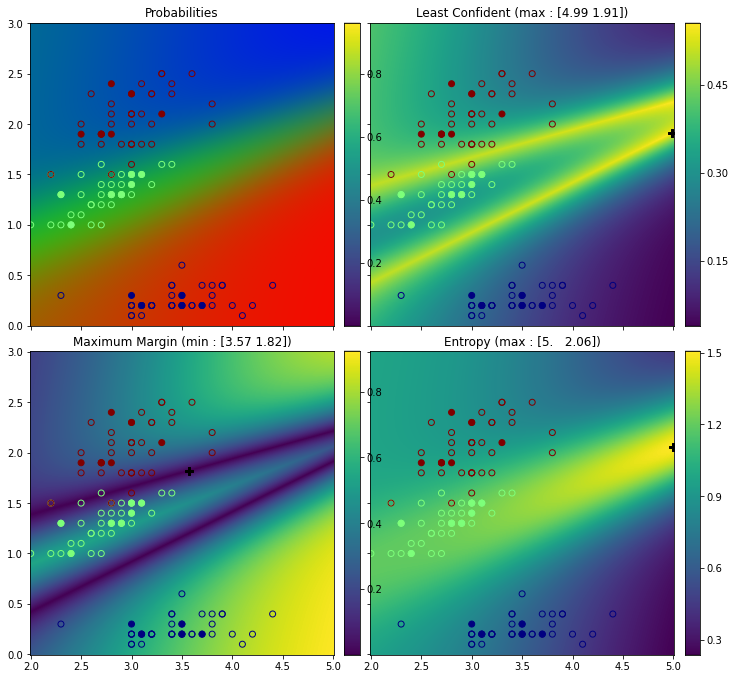

In [105]:
# Settings
n_init = 20             # Number of points to use for fitting the model
use_classes = None#[0, 1]    # None (all three classes or a list of class labels to use, e.g., [0, 1])
use_features = [1, 3]   # The two features to use. Should be in the set (0, 1, 2, 3)

# Prepare the data (extract and split)
data = prepare_data(iris, n_init, use_classes, use_features)

# Fit a logistic classifier
# (While testing this code I experienced some issues with the default
# solver (lbfgs) which is why I use different one here.
# 'liblinear' seems to most stable convergence
# also it seems to benefit a bit from more regularization (C=1e1), but this was not throughly tested
model = LogisticRegression(penalty='l2', C=1e1, solver='liblinear')
model = model.fit(data['train']['X'], data['train']['y'])

# For the sake of visualization, we are going to create a grid on
# which to evaluate probabilities and uncertainties
grid, imshow_kwargs = make_grid(data['train']['X'], data['pool']['X'])
grid_as_data = grid.transpose(1,2,0).reshape(-1, len(use_features))

# Compute the predictive probabilities ('prob') and uncertainties
# ('least_confident', 'maximum_margin', 'entropy')
prob = model.predict_proba(grid_as_data)
least_confident = evaluate_uncertainty(prob, 'least confident')
maximum_margin = evaluate_uncertainty(prob, 'maximum margin')
entropy = evaluate_uncertainty(prob, 'entropy')

# Plot the results
plot_grid(prob, least_confident, maximum_margin, entropy, data, grid, imshow_kwargs)

In the figure created by `plot_grid`, filled circles represent data points used to fit the model. Hollow circles are the data points in the pool (i.e., points which we could potentially query). Points are colored according to their *true* label. The bold black cross shows which point each sampling strategy suggests to query next. 
- (top left) The posterior probabilities plotted as RGB (in the case of two classes, blue is unused).
- (top right) Least confidence.
- (bottom left) Maximum margin.
- (bottom right). Entropy.

<font color=blue>
1. Go back and do the same using all three classes (`use_classes = None`). You can also try to use different pairs of features.
<br>2. Using three classes, the strategies should no longer agree completely on which point to sample next. Do some of them tend to agree more than others? Why?
<br>3. Are there other things which might be important to consider besides how uncertain the model is about the label of a given point? For example, your might consider whether these sampling strategies tend to suggest points similiar to those you would have chosen yourself?
<br>4. What kind of sampling scenario does this emulate? What scenario are we actually dealing with with this dataset?

## Active Learning and Random Sampling

Up until now we simply extracted a random subset of the data, used this to train the model, and evaluated probabilities and uncertainties. This enabled us to determine which point to sample next, however, we did not actually do this. As such, we have not done any 'active' learning yet. Thus, your task is now to integrate this into an activate learning scenario. Basically, this involves the following steps

- Choose some initial data points (training set)
1. Fit the model
2. Evaluate probabilities on the pool
3. Evaluate corresponding uncertainties
4. Update training set (and pool) based on the sampled point
5. Return to step 1 and repeat for some number of iterations

To track the progress you will probably also want to evaluate performance (accuracy) on a test set. This can be done using the `score` method of the model. You should also implement a random sampling approach so that we may compare the two approaches. Finally, plot the classification accuracy of both methods against the number of data available when training the model/number of iterations. One thing to note is that in order to get a stable estimate of the error, you might need to average several runs/model fits so it might be an idea to group these things into functions to easily run them multiple times.

For this exercise you should use all classes and all features, however, if you would like to plot the results, you can extract two features and plot the results in the that subspace. If you would like, you can use the function `plot_pool` to plot the uncertainties for a few iterations (along with the selected point to sample next). (This should be called between step 3 and 4.)

In [158]:
# define the functions necessary for fitting the model based on either strategy (really, most of the steps are the same)
# there is a skeleton for it below but feel free to choose a completely implement this

def update_data(data, idx): 
    #data is a dictionary
    # my best guess is that idx is the point we will sample
    data['train']['X'] = np.vstack((data['train']['X'],data['pool']['X'][idx]))
    data['train']['y'] = np.hstack((data['train']['y'],data['pool']['y'][idx]))
    data['pool']['X'] = np.delete(data['pool']['X'],idx,0)
    data['pool']['y'] = np.delete(data['pool']['y'],idx,0)
    
    return data
    
def fit_model(iris, paradigm, strategy, n_init, n_iterations, use_classes=None, use_features=None, plot=False):
    """Run n_iterations of active learning or random sampling.
    
    PARAMETERS
    ----------
    iris :
        The iris dataset object.
    paradigm : str
        One of 'active learning' or 'random'.
    strategy : str
        The uncertainty strategy to use (only used when paradigm = 
        'active learning').
    n_init : int
        The initial number of points in the training set.
    n_iterations : int
        The number of iterations to run.
    use_classes, use_features (same as for prepare_data)
    plot : bool
        Whether to plot the state at each iteration (see the
        description of plot_pool). It is probably a good idea to
        set n_iterations low when this is True.

    RETURNS
    ----------
    scores : ndarray
        The score at each iteration.    
        
    Hint: consider passing solver='liblinear', warm_start=True and setting the penalty a bit higher than default eg. pass C=1e1 to
    LogisticRegression for better performance
    """
    
    # Prepare the data (extract and split)
    data = prepare_data(iris, n_init, use_classes, use_features)
    model = LogisticRegression(penalty='l2', C=1e1, solver='liblinear', warm_start=True, multi_class='auto')
    
    scores = []
    
    if paradigm == 'random':
        model.fit(data['train']['X'], data['train']['y'])
        scores.append(model.score(data['test']['X'], data['test']['y']))
        
        sample_idx = np.random.choice(len(data['pool']['X']), 1)[0]
        data = update_data(data, sample_idx)
        
    elif paradigm == 'active learning':
        for i in range(n_iterations):
            model = model.fit(data['train']['X'], data['train']['y'])
            scores.append(model.score(data['test']['X'], data['test']['y']))
            
            # Compute the predictive probabilities ('prob') and uncertainties
            # ('least_confident', 'maximum_margin', 'entropy')
            prob = model.predict_proba(data['pool']['X'])
            evaluate_uncertainty(prob, strategy)
            sample_idx = np.argmax(evaluate_uncertainty)
            
            data = update_data(data, sample_idx)
    
    
    return scores

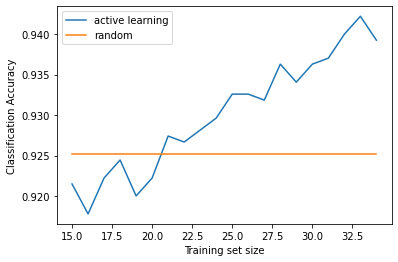

In [159]:
# run active learning and random sampling (perhaps averaging over multiple runs) and plot the results (training set size vs. classification error)

# Settings
n_avg = 50
n_iterations = 20
n_init = 15

# Average n_avg fits
scores_al = np.zeros((n_avg, n_iterations)) #scores for active learning
scores_rn = np.zeros((n_avg, n_iterations)) #scores for random sampling
for i in range(n_avg):
    scores_al[i] = fit_model(iris, 'active learning', 'least confident', n_init, n_iterations, use_classes=None, use_features=None, plot=False)
    scores_rn[i] = fit_model(iris, 'random', 'least confident', n_init, n_iterations, use_classes=None, use_features=None, plot=False)

# Plot the results
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(n_init, n_iterations+n_init), scores_al.mean(0))
ax.plot(np.arange(n_init, n_iterations+n_init), scores_rn.mean(0))
ax.legend(['active learning', 'random'])
ax.set_xlabel('Training set size')
ax.set_ylabel('Classification Accuracy')
print('')

A few things you may want to consider.
<font color=blue>
1. To get a stable estimate of the performance you will probably need to average several runs of active learning and random sampling. What could be the reason (or a reason) for that?
2. Do active learning seem to make a difference for this particular problem? How does settings like number of initial points used and number of queries from the pool affect this?
3. Is the convergence steady across the iterations, or do you observe any degradation in the performance (dips) if so can you think of any reason that this might happen?
4. You can try to look into the `warm_start` argument of the `LogisticRegression` class and see if that makes a difference.